# Poor Man's Gaussian Process Latent Variable Model

In [1]:
import numpy as np
import jax.numpy as jnp
import jax.random as jr
import poor_man_gplvm as pmg
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from scipy.interpolate import interp1d
import os

from core import *

%matplotlib widget

## Configuration

In [2]:
# ----------------------------- Config ---------------------------------

# Data paths and session info
DATA_DIR = r"\\research-cifs.nyumc.org\research\buzsakilab\Homes\voerom01\Bilat_HPC\Bilat_R02\Bilat_R02_20251106"
FIG_DIR = r"\\research-cifs.nyumc.org\research\buzsakilab\Homes\voerom01\Bilat_HPC\Bilat_R02\Bilat_R02_20251106\analysisFigures"
SESSION_NAME = "pre_sleep_g0"
BASE_NAME = "Bilat_R02_20251106"
PROBES = [0, 1, 2, 3]


# Spike rate computation parameters
WINDOW_SIZE = 0.04         # s
STEP_SIZE   = 0.04        # s
USE_UNITS   = "good"       # {'all', 'good', 'mua'}


# Filtering thresholds
MIN_TOTAL_SPIKES   = 100
MIN_MEAN_RATE_HZ   = 0.01
MIN_PRESENCE_RATIO = 0.75
N_TIME_BINS        = 100    # coarse bins for presence ratio


# defining the region dictionary. Keys are probe numbers, values are dictionaries which are further mapping shanks to regions
#region_dict = {0: {0: 'CA1', 1: 'RSP', 2: 'CA3', 3: 'CA1', 4: 'RSP', 5: 'CA3', 6: 'CA1', 7: 'RSP'}, 1: {0: 'CA3', 1: 'CA1', 2: 'CA2', 3: 'A1', 4: 'S1'}, 2: {0: 'CA3', 1: 'Th', 2: 'V1', 3: 'Th', 4: 'CA1', 5: 'V1', 6: 'CA1', 7: 'V1'}} UDS
region_dict = {
    0: {0: 'CA1', 1: 'Th', 2: 'CA1', 3: 'CA1', 4: 'CA1', 5: 'CA1', 6: 'CA1', 7: 'CA1'},
    1: {0: 'CA1', 1: 'CA1', 2: 'CA1', 3: 'CA1', 4: 'CA1', 5: 'CA1', 6: 'CA1', 7: 'CA1'},
    2: {0: 'CA1', 1: 'CA1', 2: 'CA1', 3: 'CA1', 4: 'CA1', 5: 'CA1', 6:'CA1'}, 
    3: {0: 'CA1', 1: 'CA1', 2: 'CA1', 3: 'CA1', 4: 'CA1', 5: 'CA1', 6: 'CA1', 7: 'CA1'}
}


# defining the hemisphere dictionary. Keys are probe numbers, values are 'L' or 'R' for left/right hemisphere
hemisphere_dict = {0: 'L', 1: 'L', 2: 'R', 3: 'R'}

# Create figure directory if it doesn't exist
os.makedirs(FIG_DIR, exist_ok=True)

## Loading the spike counts

In [3]:
# ------------------------ Load spike rate matrices ------------------------
spike_count_matrices = {}
cell_types = {}
regions = {}
for probe in PROBES:
    # Get the raw spike counts and the zscored and smoothed spike rates
    ks_dir = os.path.join(DATA_DIR, f'Kilosort_imec{probe}_ks4')
    spike_count_matrix, time_bins, units = compute_spike_counts(str(ks_dir), WINDOW_SIZE, STEP_SIZE, USE_UNITS, 0.0, False, adj = '_sec_adj')


    # computing the filtering metrics
    total_spikes   = spike_count_matrix.sum(axis=1)         
    mean_counts   = spike_count_matrix.mean(axis=1)
    presence_ratio = get_presence_ratio(spike_count_matrix, time_bins, N_TIME_BINS)

    mask = (
        (total_spikes >= MIN_TOTAL_SPIKES) &
        (mean_counts >= MIN_MEAN_RATE_HZ) &
        (presence_ratio >= MIN_PRESENCE_RATIO)
    )


    # Apply mask to spike rate matrix and unit list
    spike_count_matrix = spike_count_matrix[mask, :]
    units = [u for u, keep in zip(units, mask) if keep]
    print(f"Probe {probe}: Keeping {mask.sum()} / {mask.sum() + (~mask).sum()} units after filtering.\nspike_count_matrix shape: {spike_count_matrix.shape}\n")

    # remove units based on presence ratio
    spike_count_matrices[probe] = (spike_count_matrix, time_bins, units)


    # Load the cell metrics
    cell_metrics_file = os.path.join(DATA_DIR, f'{BASE_NAME}_imec{probe}.cell_metrics.cellinfo.mat')
    cell_type = loadmat(cell_metrics_file)['cell_metrics']['putativeCellType'][0,0].flatten()
    shank_ids = loadmat(cell_metrics_file)['cell_metrics']['shankID'][0,0].flatten()


    # keeping only the string labels
    cell_type = np.array([ct[0] if isinstance(ct, np.ndarray) else ct for ct in cell_type])

    # removing mask applied units from cell type
    cell_types[probe] = cell_type[mask]
    regions[probe] = np.array([region_dict[probe][shank_id-1] for shank_id in shank_ids[mask]])  # shank IDs are 1-based

Probe 0: Keeping 45 / 80 units after filtering.
spike_count_matrix shape: (45, 263023)

Probe 1: Keeping 38 / 49 units after filtering.
spike_count_matrix shape: (38, 263023)

Probe 2: Keeping 159 / 299 units after filtering.
spike_count_matrix shape: (159, 263023)

Probe 3: Keeping 221 / 305 units after filtering.
spike_count_matrix shape: (221, 263023)



## Extracting the tracking data

Number of frames: 308232
first row of tracking data: [ 0.00000e+00  0.00000e+00  6.81780e-02 -1.61595e-01 -9.67768e-01
 -1.80732e-01 -1.07200e-03  2.23371e-01  5.83550e-02  4.13000e-04]
Trimming TTLs from 308285 to 308232
Tracking start time: 3926.353 s, end time: 6494.814 s, duration: 2568.461 s


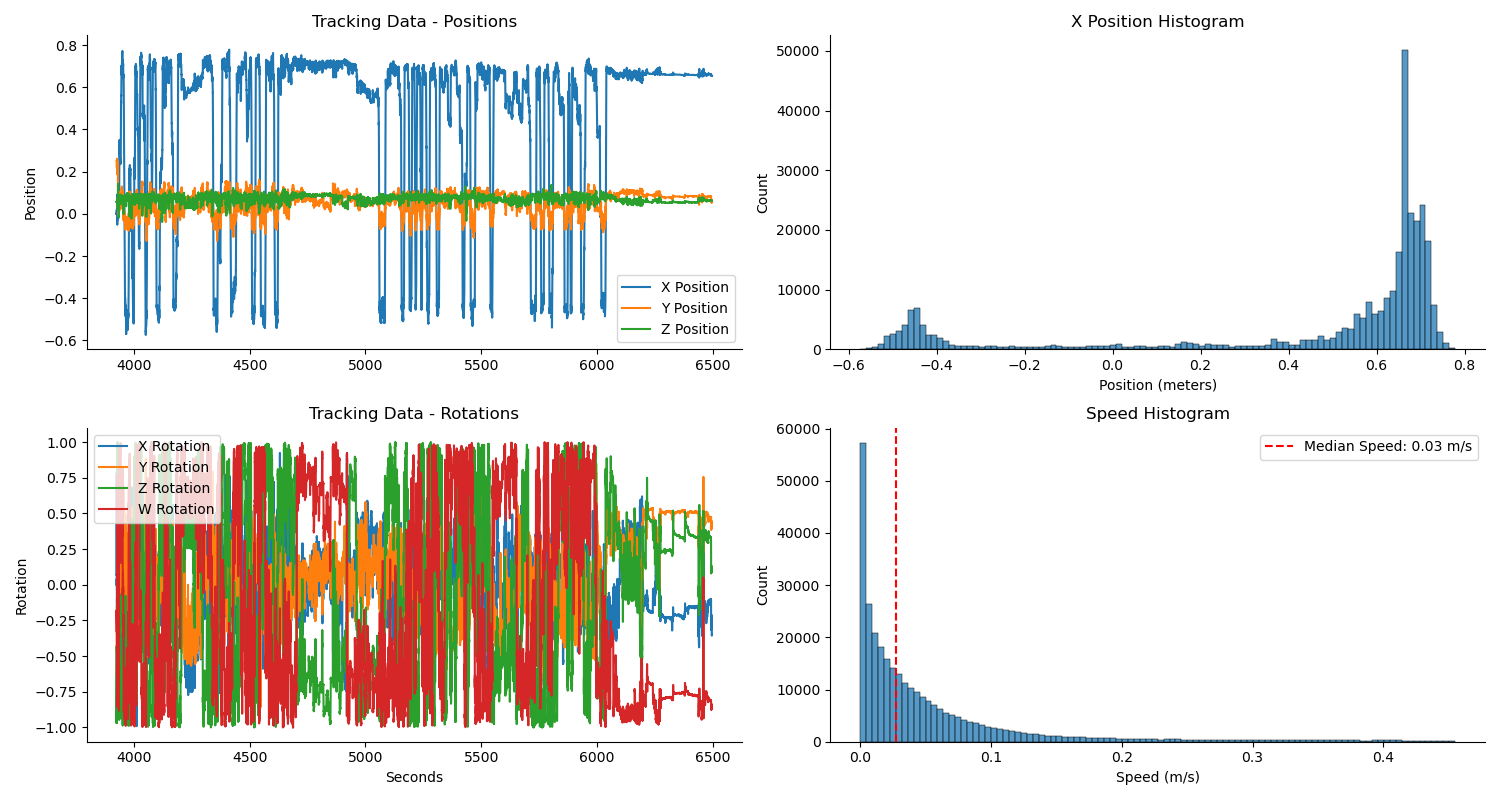

In [4]:
use_position = 'x'  # 'x', 'y', or 'z'

# Loading the manually extracted TTL times
manual_ttl_file = os.path.join(DATA_DIR, 'manual_ttl_extraction.csv')
manual_ttls_df = pd.read_csv(manual_ttl_file)
ttls = manual_ttls_df['ttl_times_sec'].values

# Loadding in the tracking data
tracking_file = os.path.join(DATA_DIR, "Bilat_R02_20251106_linear_maze_000.csv")
tracking_data = np.genfromtxt(tracking_file, delimiter=",", skip_header=7)
frames = tracking_data[:,0]
print(f'Number of frames: {len(frames)}')
print(f'first row of tracking data: {tracking_data[0,:]}')


# Sometimes there are a few more frames after the last TTL or more TTLs than frames. We will trim the data to the shortest length.
if len(frames) < len(ttls):
    print(f'Trimming TTLs from {len(ttls)} to {len(frames)}')
    ttls = ttls[:len(frames)]
    tracking_data = tracking_data[:len(frames),:]
elif len(frames) > len(ttls):
    print(f'Trimming frames from {len(frames)} to {len(ttls)}')
    frames = frames[:len(ttls)]
    tracking_data = tracking_data[:len(ttls),:]

# printing the start and end times
print(f'Tracking start time: {ttls[0]:.3f} s, end time: {ttls[-1]:.3f} s, duration: {ttls[-1]-ttls[0]:.3f} s')


# fill missing values or nan with linear interpolation
for i in range(tracking_data.shape[1]):
    col = tracking_data[:,i]
    nans = np.isnan(col)
    if np.any(nans):
        not_nans = ~nans
        interp_func_col = interp1d(frames[not_nans], col[not_nans], bounds_error=False, fill_value="extrapolate")
        col[nans] = interp_func_col(frames[nans])
        tracking_data[:,i] = col

# extract x, y, z positions and rotations
x_rotations = tracking_data[:,2]
y_rotations = tracking_data[:,3]
z_rotations = tracking_data[:,4]
w_rotations = tracking_data[:,5]
x_positions = tracking_data[:,6]
y_positions = tracking_data[:,7]
z_positions = tracking_data[:,8]

# setting the pos_raw to the selected position axis
if use_position == 'x':
    pos_raw = x_positions
elif use_position == 'y':
    pos_raw = y_positions
elif use_position == 'z':
    pos_raw = z_positions

# getting the speed
speed = np.abs(np.gradient(pos_raw) / np.gradient(ttls))  # speed in m/s

# Plotting the tracking data
fig, axs = plt.subplots(2, 2, figsize=(15,8))

sns.lineplot(ax=axs[0,0], x=ttls, y=x_positions, label='X Position')
sns.lineplot(ax=axs[0,0], x=ttls, y=y_positions, label='Y Position')
sns.lineplot(ax=axs[0,0], x=ttls, y=z_positions, label='Z Position')
axs[0,0].set_ylabel('Position')
axs[0,0].set_title('Tracking Data - Positions')

sns.lineplot(ax=axs[1, 0], x=ttls, y=x_rotations, label='X Rotation')
sns.lineplot(ax=axs[1, 0], x=ttls, y=y_rotations, label='Y Rotation')
sns.lineplot(ax=axs[1, 0], x=ttls, y=z_rotations, label='Z Rotation')
sns.lineplot(ax=axs[1, 0], x=ttls, y=w_rotations, label='W Rotation')
axs[1, 0].set_xlabel('Seconds')
axs[1, 0].set_ylabel('Rotation')
axs[1, 0].set_title('Tracking Data - Rotations')

sns.histplot(ax=axs[0, 1], x=pos_raw, bins=100)
axs[0, 1].set_xlabel('Position (meters)')
axs[0, 1].set_ylabel('Count')
axs[0, 1].set_title(f'{use_position.upper()} Position Histogram')

sns.histplot(ax=axs[1, 1], x=speed[speed < np.percentile(speed, 99)], bins=100)
axs[1, 1].set_xlabel('Speed (m/s)')
axs[1, 1].set_ylabel('Count')
axs[1, 1].set_title('Speed Histogram')
axs[1, 1].axvline(x = np.median(speed), color='red', linestyle='--', label=f'Median Speed: {np.median(speed):.2f} m/s')
axs[1, 1].legend()
sns.despine()
plt.tight_layout()
#plt.savefig(os.path.join(FIG_DIR, "tracking_data.png"), dpi=300)
plt.show()


### Bining position

In [5]:
N_SPATIAL_BINS = 50
POS_MIN = -0.5
POS_MAX = 0.7

# compute the spatial bin edges
bin_edges = np.linspace(POS_MIN, POS_MAX, N_SPATIAL_BINS + 1)

# Creating interpolation function for position
pos_interp_func = interp1d(ttls, pos_raw, kind = 'linear', bounds_error=False, fill_value=np.nan)

# getting reference time from probe with shortest timebins
tb_ref = None
for probe in PROBES:
    _, tb_probe, _ = spike_count_matrices[probe]
    if tb_ref is None:
        tb_ref = tb_probe
    elif len(tb_probe) < len(tb_ref):
        tb_ref = tb_probe

# Build canonical masks on the *reference* tb_ref
pos_ref = pos_interp_func(tb_ref)
valid_ttl  = (tb_ref >= np.min(ttls)) & (tb_ref <= np.max(ttls))
print(f'number of valid TTL timebins: {valid_ttl.sum()} / {len(tb_ref)}')
finite_pos = np.isfinite(pos_ref)
print(f'number of finite position timebins: {finite_pos.sum()} / {len(tb_ref)}')

mask = valid_ttl & finite_pos

# digitize positions into spatial bins
pos_bins = np.digitize(pos_ref[mask], bin_edges) - 1  # bins are 0-indexed

number of valid TTL timebins: 64212 / 263023
number of finite position timebins: 64212 / 263023


### Aligning neural data to position

In [6]:
# ------------------------ Plotting spike raster for each hemisphere and the binarized positions------------------------
REGIONS = ['CA1']
UNIT_TYPES = ['Pyramidal Cell']

# preparing the lists to collect spike rates
selected_spike_counts_L = []
selected_spike_counts_R = []

# looping over probes to collect spike rates
for probe in PROBES:

    spike_count_matrix, probe_times, units = spike_count_matrices[probe]  # (n_units, n_timebins)
    hemisphere = hemisphere_dict[probe]


    # cropping the probe times to match the reference timebins
    print(f'Probe {probe} timebins length {len(probe_times)}: reference timebins length {len(tb_ref)}')
    start_time, end_time = np.min(tb_ref), np.max(tb_ref)
    valid_time_probe = (probe_times >= start_time) & (probe_times <= end_time)

    # check if all time values are now equal
    probe_times = probe_times[valid_time_probe]
    spike_count_matrix = spike_count_matrix[:, valid_time_probe]
        
    if np.allclose(probe_times, tb_ref, rtol=0, atol=1e-9):
        print(f'Probe {probe} timebins successfully matched to reference timebins after cropping.')
        print(f'sum of differences: {np.sum(probe_times - tb_ref)}\n')
    else:
        raise ValueError(f'Probe {probe} timebins do not match reference timebins after cropping. Lengths: {len(probe_times)} vs {len(tb_ref)}')


    # filtering out timebins outside the TTL range and speed threshold
    spike_counts = spike_count_matrix[:, mask]


    # getting cell types and regions for the current probe
    ct_probe = np.asarray(cell_types[probe])                    
    rgn_arr = regions[probe]                                   

    # select units from the selected regions
    unit_sel = np.where(
        (np.isin(ct_probe, UNIT_TYPES)) &
        (np.isin(rgn_arr, REGIONS))
    )[0]
    if unit_sel.size == 0:
        continue

    if hemisphere == 'L':
        selected_spike_counts_L.append(spike_counts[unit_sel, :])
    elif hemisphere == 'R':
        selected_spike_counts_R.append(spike_counts[unit_sel, :])
    else:
        raise ValueError(f'Unknown hemisphere {hemisphere} for probe {probe}')

# concatenating the selected spike rates across probes
if (len(selected_spike_counts_L) == 0 and len(selected_spike_counts_R) == 0):
    raise RuntimeError("No units found for the chosen regions after filtering.")

spike_counts_concat_L = np.vstack(selected_spike_counts_L) if len(selected_spike_counts_L) > 0 else np.empty((0, 0))
spike_counts_concat_R = np.vstack(selected_spike_counts_R) if len(selected_spike_counts_R) > 0 else np.empty((0, 0))

# sort the units based on correlation
sorted_spike_counts_concat_L = sort_units(spike_counts_concat_L, mode='corr')
sorted_spike_counts_concat_R = sort_units(spike_counts_concat_R, mode='corr')

# getting the time vector in seconds
times = tb_ref[mask] - tb_ref[0]

print(f'sorted_counts_concat_L shape: {sorted_spike_counts_concat_L.shape}')
print(f'sorted_counts_concat_R shape: {sorted_spike_counts_concat_R.shape}')
print(f'pos_bins shape: {pos_bins.shape}')
print(f'pos_ref shape: {pos_ref.shape}')
print(f'times shape: {times.shape}')

Probe 0 timebins length 263023: reference timebins length 263023
Probe 0 timebins successfully matched to reference timebins after cropping.
sum of differences: 0.0

Probe 1 timebins length 263023: reference timebins length 263023
Probe 1 timebins successfully matched to reference timebins after cropping.
sum of differences: 0.0

Probe 2 timebins length 263023: reference timebins length 263023
Probe 2 timebins successfully matched to reference timebins after cropping.
sum of differences: 0.0

Probe 3 timebins length 263023: reference timebins length 263023
Probe 3 timebins successfully matched to reference timebins after cropping.
sum of differences: 0.0

sorted_counts_concat_L shape: (53, 64212)
sorted_counts_concat_R shape: (207, 64212)
pos_bins shape: (64212,)
pos_ref shape: (263023,)
times shape: (64212,)


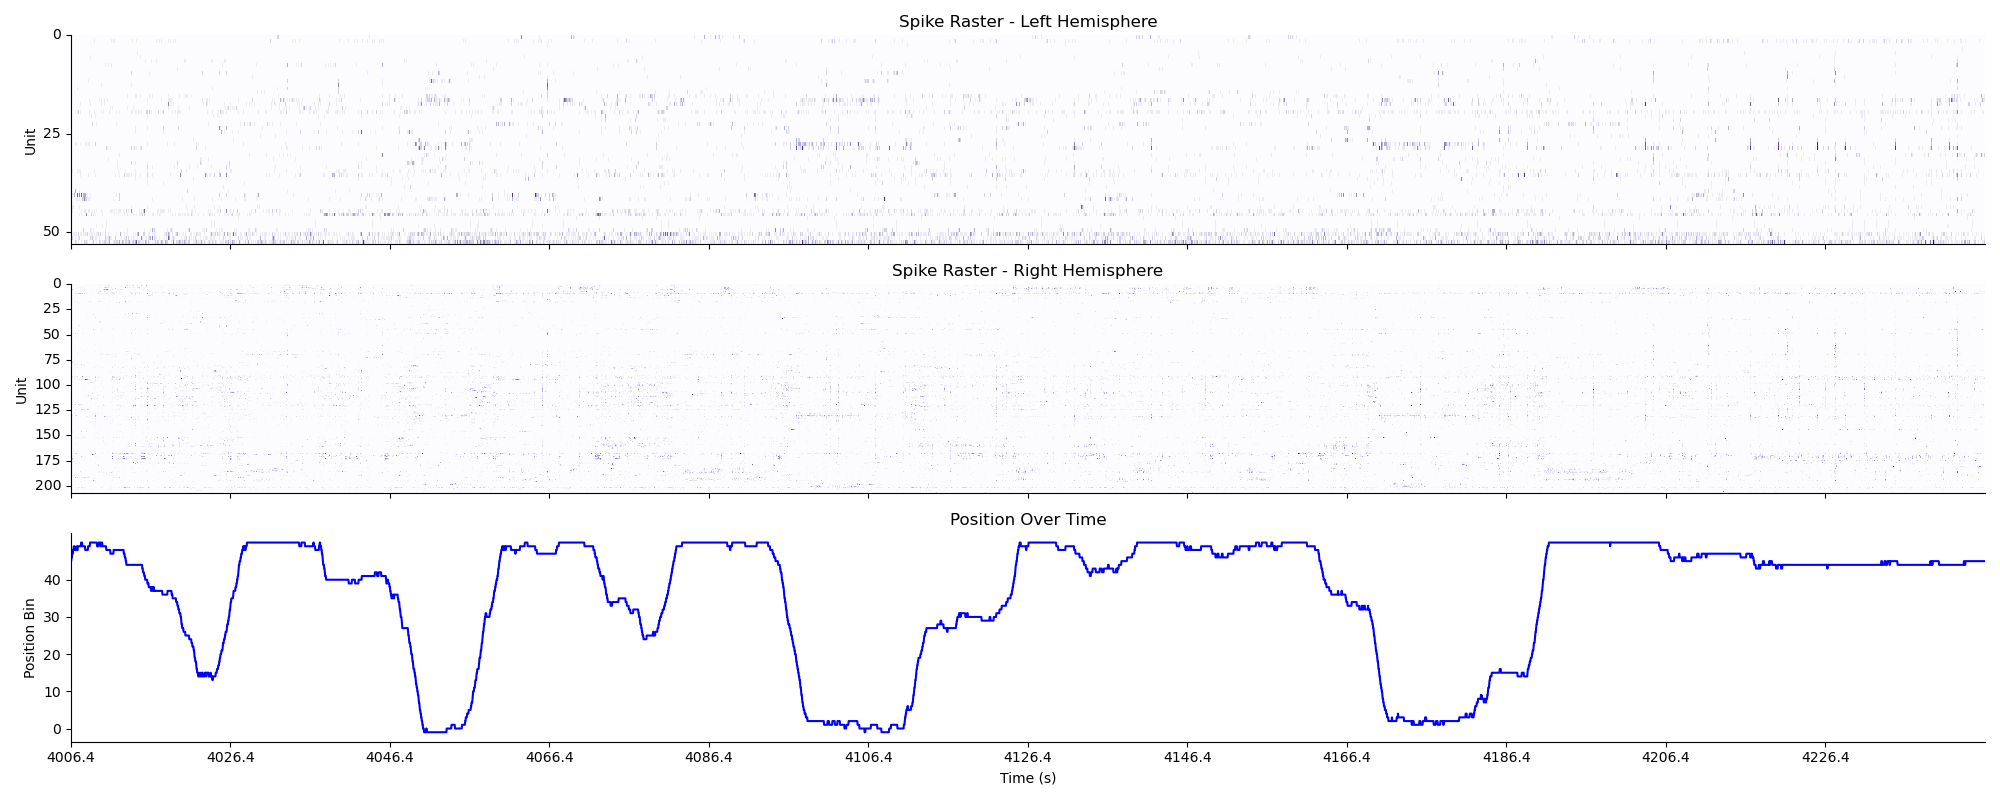

In [17]:
START = 2000
STOP = 8000

# indices within the sliced segment (0 .. STOP-START-1)
x_idx = np.arange(STOP - START)

fig, axs = plt.subplots(3, 1, figsize=(20, 8), sharex=True)

# --- Left hemisphere raster ---
sns.heatmap(
    ax=axs[0],
    data=sorted_spike_counts_concat_L[:, START:STOP],
    cmap='Purples',
    cbar=False
)
axs[0].set_ylabel('Unit')
axs[0].set_title('Spike Raster - Left Hemisphere')
axs[0].set_yticks(np.arange(0, sorted_spike_counts_concat_L.shape[0], 25))
axs[0].set_yticklabels(np.arange(0, sorted_spike_counts_concat_L.shape[0], 25))

# --- Right hemisphere raster ---
sns.heatmap(
    ax=axs[1],
    data=sorted_spike_counts_concat_R[:, START:STOP],
    cmap='Purples',
    cbar=False
)
axs[1].set_ylabel('Unit')
axs[1].set_title('Spike Raster - Right Hemisphere')
axs[1].set_yticks(np.arange(0, sorted_spike_counts_concat_R.shape[0], 25))
axs[1].set_yticklabels(np.arange(0, sorted_spike_counts_concat_R.shape[0], 25))

# --- Position trace ---
# IMPORTANT: use the same x_idx as x, not times[]
sns.lineplot(
    ax=axs[2],
    x=x_idx,
    y=pos_bins[START:STOP],
    color='blue'
)
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Position Bin')
axs[2].set_title('Position Over Time')

axs[2].set_yticks(np.arange(0, N_SPATIAL_BINS, 10))
axs[2].set_yticklabels(np.arange(0, N_SPATIAL_BINS, 10))

# Now set ticks in index space, but label them with seconds
tick_idx = np.arange(0, STOP - START, 500)  # index within the window
tick_labels = np.round(times[START:STOP:500], 1)

axs[2].set_xticks(tick_idx)
axs[2].set_xticklabels(tick_labels)

sns.despine()
plt.tight_layout()
plt.show()

## Fitting the model

In [18]:
# define the models for the left and right hemispheres
model_l=pmg.PoissonGPLVMJump1D(sorted_spike_counts_concat_L.shape[0], n_latent_bin=N_SPATIAL_BINS, movement_variance=1, tuning_lengthscale=10.)
model_r=pmg.PoissonGPLVMJump1D(sorted_spike_counts_concat_R.shape[0], n_latent_bin=N_SPATIAL_BINS, movement_variance=1, tuning_lengthscale=10.)

# fitting the models
em_res_r = model_r.fit_em(sorted_spike_counts_concat_R.T, key=jr.PRNGKey(3), n_iter=20, posterior_init=None, ma_neuron=None, ma_latent=None, n_time_per_chunk=10000)
em_res_l = model_l.fit_em(sorted_spike_counts_concat_L.T, key=jr.PRNGKey(3), n_iter=20, posterior_init=None, ma_neuron=None, ma_latent=None, n_time_per_chunk=10000)

c:\Users\SB13FLPC020\miniforge3\envs\pmgplvm\Lib\site-packages\jax\_src\abstract_arrays.py:68: RuntimeWarning:

overflow encountered in cast

c:\Users\SB13FLPC020\miniforge3\envs\pmgplvm\Lib\site-packages\jax\_src\interpreters\xla.py:158: RuntimeWarning:

overflow encountered in cast

EM:   0%|          | 0/20 [00:00<?, ?it/s]c:\Users\SB13FLPC020\miniforge3\envs\pmgplvm\Lib\site-packages\jax\_src\abstract_arrays.py:68: RuntimeWarning:

overflow encountered in cast

c:\Users\SB13FLPC020\miniforge3\envs\pmgplvm\Lib\site-packages\jax\_src\lax\lax.py:2476: RuntimeWarning:

overflow encountered in cast

EM: 100%|██████████| 20/20 [06:18<00:00, 18.92s/it]


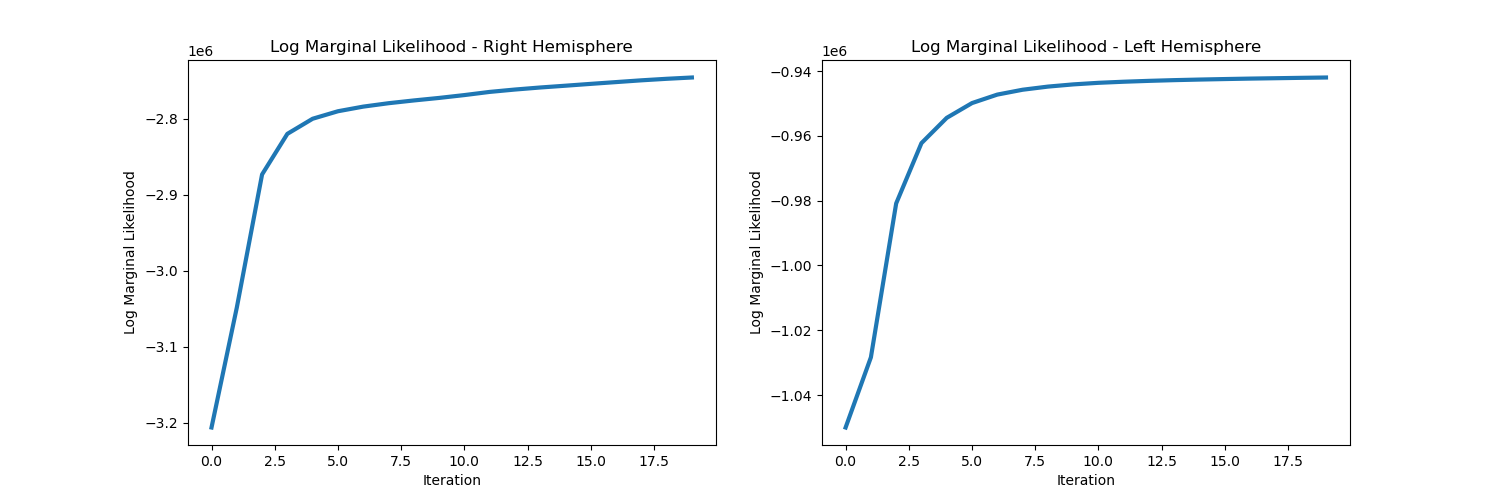

In [20]:
# monitor training
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(em_res_r['log_marginal_l'], linewidth=3)
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Log Marginal Likelihood')
axs[0].set_title('Log Marginal Likelihood - Right Hemisphere')
axs[1].plot(em_res_l['log_marginal_l'], linewidth=3)
axs[1].set_xlabel('Iteration') 
axs[1].set_ylabel('Log Marginal Likelihood')
axs[1].set_title('Log Marginal Likelihood - Left Hemisphere')
plt.show()

## Testing the model

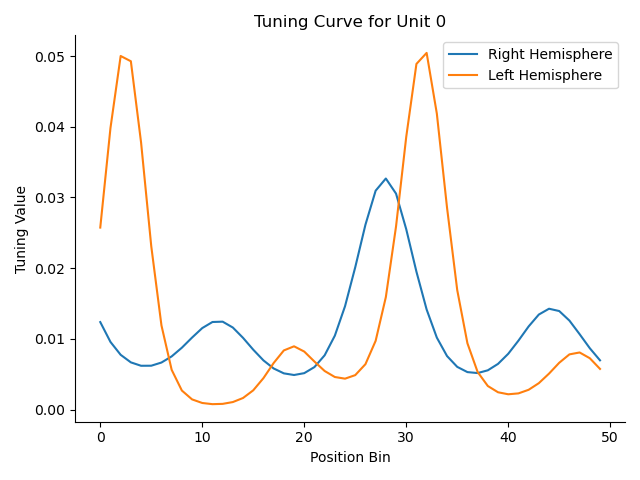

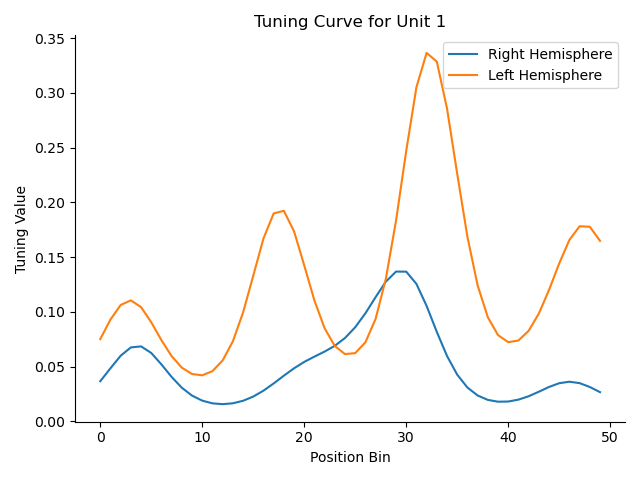

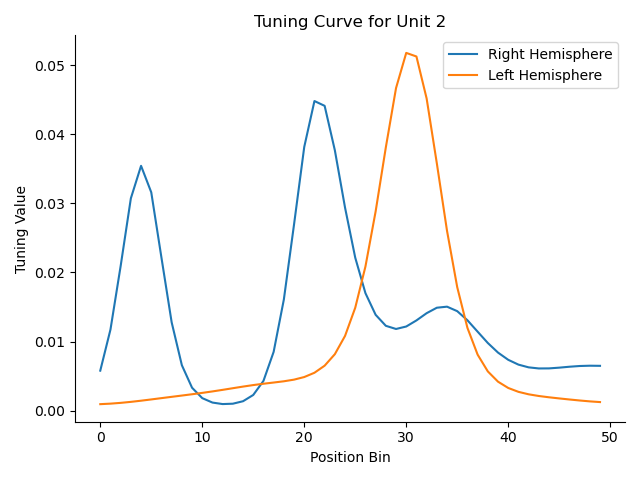

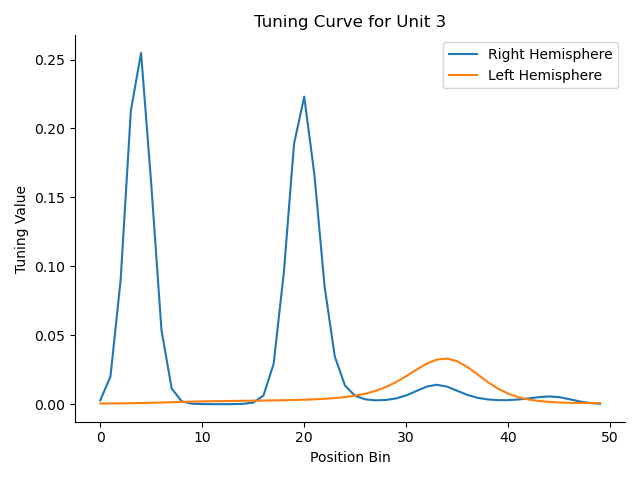

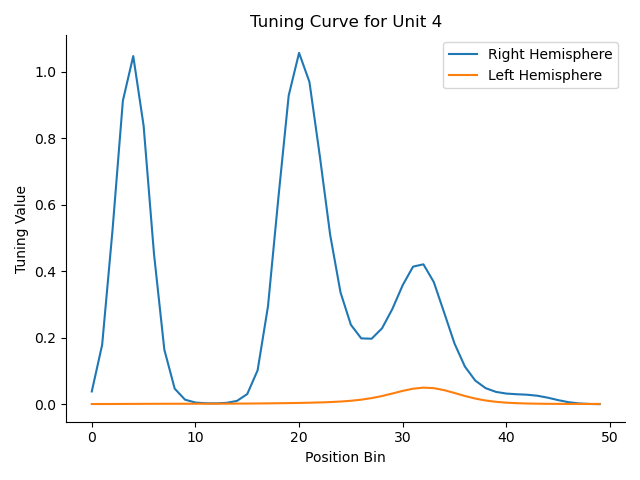

In [21]:
tuning_curves_r = model_r.tuning
tuning_curves_l = model_l.tuning
for neuron in range(5):
    plt.figure()
    plt.plot(tuning_curves_r[:, neuron], label='Right Hemisphere')
    plt.plot(tuning_curves_l[:, neuron], label='Left Hemisphere')
    plt.title(f'Tuning Curve for Unit {neuron}')
    plt.xlabel('Position Bin')
    plt.ylabel('Tuning Value')
    plt.legend()
    sns.despine()
    plt.tight_layout()
    plt.show()

In [22]:
decode_res_r = model_r.decode_latent(sorted_spike_counts_concat_R.T)
decode_res_l = model_l.decode_latent(sorted_spike_counts_concat_L.T)

latent_posteriors_r = decode_res_r['posterior_latent_marg']
jump_prob_r = decode_res_r['posterior_dynamics_marg'][:,1]
continuous_prob_r = decode_res_r['posterior_dynamics_marg'][:,0]

latent_posteriors_l = decode_res_l['posterior_latent_marg']
jump_prob_l = decode_res_l['posterior_dynamics_marg'][:,1]
continuous_prob_l = decode_res_l['posterior_dynamics_marg'][:,0]

print(f'latent_posteriors_r shape: {latent_posteriors_r.shape}')
print(f'jump_prob_r shape: {jump_prob_r.shape}')
print(f'continuous_prob_r shape: {continuous_prob_r.shape}')
print(f'latent_posteriors_l shape: {latent_posteriors_l.shape}')
print(f'jump_prob_l shape: {jump_prob_l.shape}')
print(f'continuous_prob_l shape: {continuous_prob_l.shape}')



latent_posteriors_r shape: (64212, 50)
jump_prob_r shape: (64212,)
continuous_prob_r shape: (64212,)
latent_posteriors_l shape: (64212, 50)
jump_prob_l shape: (64212,)
continuous_prob_l shape: (64212,)


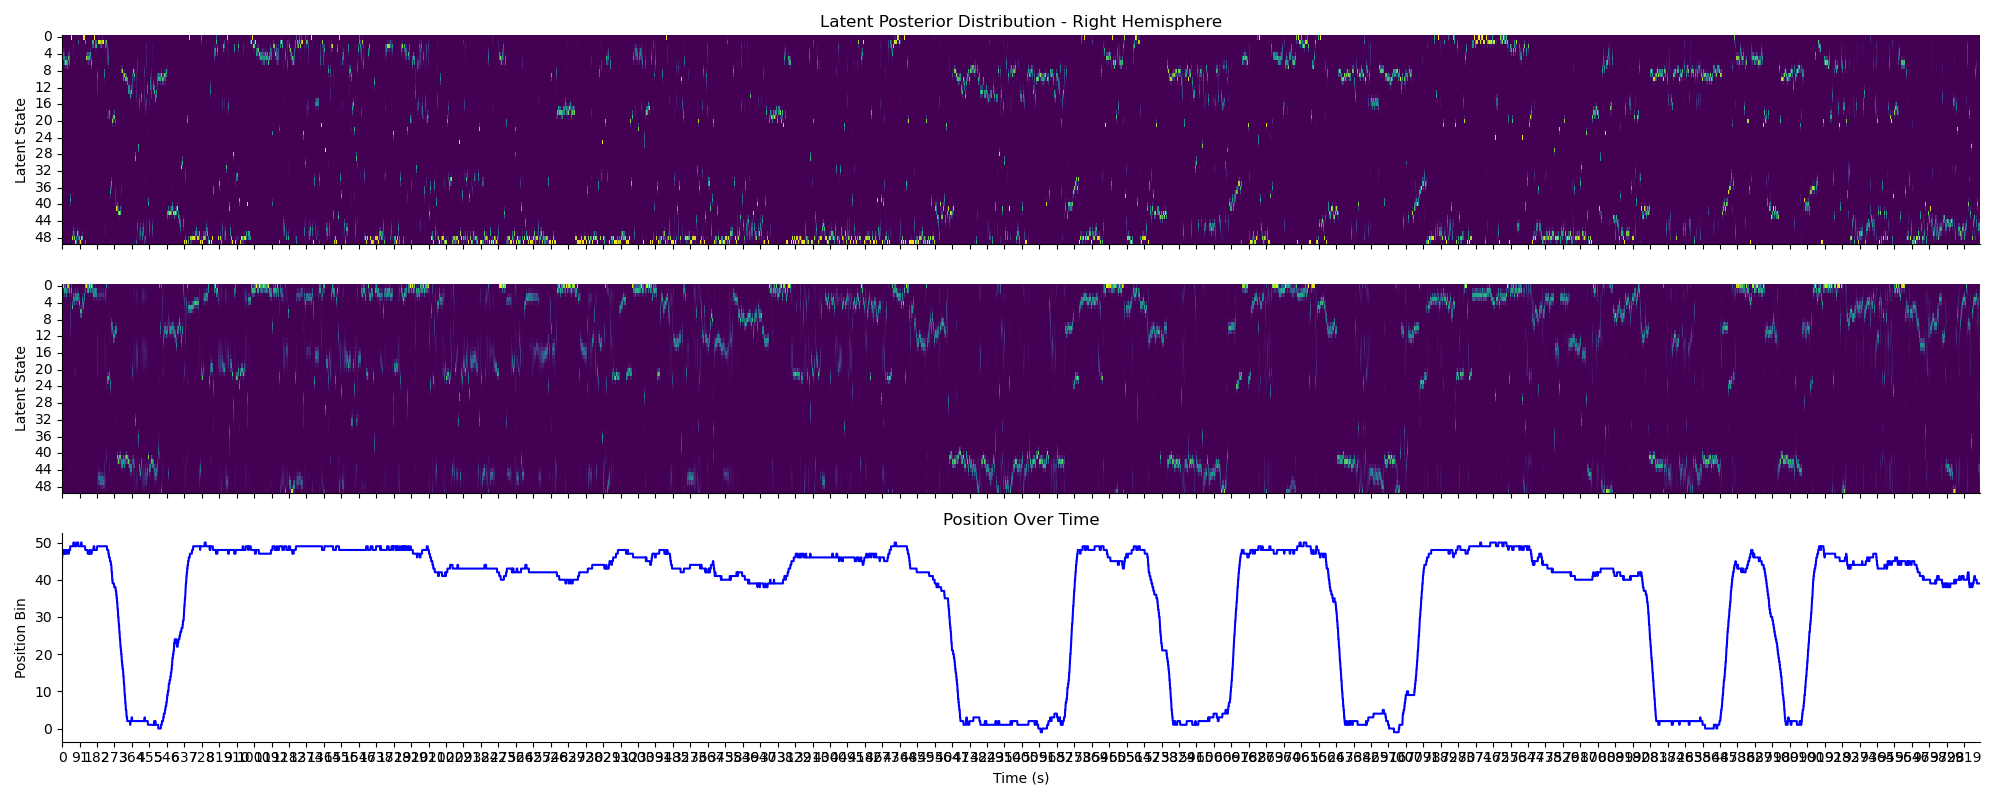

In [27]:
START = 40_000
STOP = 50_000


# plotting the latent posteriors and the jump probabilities
fig, axs = plt.subplots(3, 1, figsize=(20, 8), sharex=True)
sns.heatmap(ax=axs[0], data=latent_posteriors_r[START:STOP, :].T, cmap='viridis', cbar=False)
axs[0].set_ylabel('Latent State')
axs[0].set_title('Latent Posterior Distribution - Right Hemisphere')

sns.heatmap(ax=axs[1], data=latent_posteriors_l[START:STOP, :].T, cmap='viridis', cbar=False)
axs[1].set_ylabel('Latent State')



# --- Position trace ---
sns.lineplot(ax=axs[2], x=np.arange(STOP-START), y=pos_bins[START:STOP], color='blue')
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Position Bin')
axs[2].set_title('Position Over Time')


sns.despine()
plt.tight_layout()
plt.show()